### Conditional density estimation with a neural spline flow

The model is as follows:
$$\mu \sim \text{Uniform}(-2, 2)$$
$$x_i \sim N(\mu, 1) \quad \text{for}\ i\ \text{in}\ 1,2$$

We will try to infer the conditional distribution $p(x|\mu)$ using a conditional normalizing flow. For more examples of architectures, see unconditional_examples.ipynb. Here, we will use a `RationalQuadraticSpline` bijection with a `CouplingFlow` architecture.


In [1]:
from jax import random
import jax.numpy as jnp
from flowjax.flows import CouplingFlow
from flowjax.bijections.transformers import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt

In [2]:
key, x_key, cond_key = random.split(random.PRNGKey(0), 3)
cond = random.uniform(cond_key, (10000, 1), minval=-2, maxval=2)
x = random.normal(x_key, (10000, 2)) + cond

In [4]:
key, subkey = random.split(key)

flow = CouplingFlow(
    key=subkey,
    base_dist=Normal(x.shape[1]),
    transformer=RationalQuadraticSpline(K=8, B=3), # 8 spline segments.
    cond_dim=cond.shape[1]
    )

key, subkey = random.split(key)
flow, losses = train_distribution(subkey, flow, x, cond)

 74%|███████▍  | 37/50 [02:07<00:44,  3.45s/it, train=3.1, val=3.07] 

Max patience reached.


## Sampling
We can now sample from the flow, for example conditioning on $\mu = 1$, which should be approximately a two dimensional $N(1, 1)$.


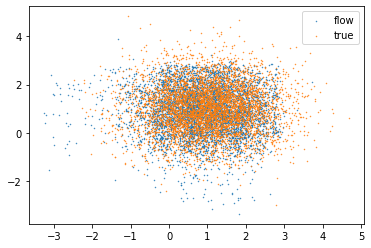

In [4]:
n = 5000
key, flow_key, true_key = random.split(key, 3)
mu = jnp.array([1])
sample = flow.sample(flow_key, condition=mu, n=n)
true = random.normal(true_key, sample.shape) + 1
plt.scatter(x = sample[:, 0], y = sample[:, 1], s=0.2, label="flow")
plt.scatter(x = true[:, 0], y = true[:, 1], s=0.2, label="true")
plt.legend()

Alternatively, we can provide a matrix of conditioning variables, to sample once for each row of the conditioning variable. For example, using $\mu \in [-2, 2]$

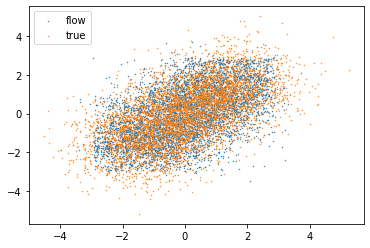

In [5]:
key, flow_key, true_key = random.split(key, 3)
mu = jnp.linspace(-2, 2, n)[:, None]
sample = flow.sample(flow_key, condition=mu)
true = random.normal(true_key, sample.shape) + mu
plt.scatter(x = sample[:, 0], y = sample[:, 1], s=0.2, label="flow")
plt.scatter(x = true[:, 0], y = true[:, 1], s=0.2, label="true")
plt.legend()

### Density evaluation
We can evaluate the density at arbitrary points

In [6]:
print(flow.log_prob(sample[:5], condition=mu[:5]))  # Inputs and conditions matched across rows
print(flow.log_prob(sample[:5], condition=mu[-1]))  # Several inputs with specific condition
print(flow.log_prob(sample[0], condition=mu[:5]))  # Specific input with several conditions

[-2.6955183 -1.4419718 -3.0530443 -2.1306558 -2.7470438]
[-11.675617 -13.645542  -9.299959 -11.738617 -10.108554]
[-2.6955183 -2.6950781 -2.694637  -2.6942008 -2.6937642]
